In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
plt.rcParams.update({'font.size': 18})

In [2]:
# Filepaths
RAW_DATA_FILENAME = "Data/Elysium_hotfire_1/hotfire_1_DAQ_test_1.csv"
PROCESSED_DATA_FILENAME = "Data/Elysium_hotfire_1/processed_data.csv"
TRIMMED_DATA_FILENAME = "Data/Elysium_hotfire_1/trimmed_data.csv"

# Attempt to remake animations?
REMAKE_PRESSURE = False
REMAKE_PRESSURE_2 = False
REMAKE_THRUST = False

# Smoothing rolling average window size
WINDOW = 11

# String Constants (keys)
P1 = "Source N2O Pressure (P1) [psi]"
P2 = "Source Fuel Pressure (P2) [psi]"
P3 = "Injector N2O Pressure (P3) [psi]"
P4 = "Injector Fuel Pressure (P4) [psi]"
P5 = "Source GN2 Pressure (P5) [psi]"
P6 = "Chamber Pressure (P6) [psi]"
T1 = "Source N2O Temp (T1) [°C]"
L1 = "Top Force (L1) [lbs]"
L2 = "Bottom Left Force (L2) [lbs]"
L3 = "Bottom Right Force (L3) [lbs]"

# Important Timestamps
T_0_CALIBRATION = 1733253843084
PURGE_1_START = (1733253840484 - T_0_CALIBRATION) / 1000
PURGE_1_END = (1733253842484 - T_0_CALIBRATION) / 1000
MAINS_OPEN = (1733253842985 - T_0_CALIBRATION) / 1000
IGNITION_CMD = 0
MAINS_CLOSE = (1733253846484 - T_0_CALIBRATION) / 1000
PURGE_2_END = (1733253848484 - T_0_CALIBRATION) / 1000
EVENT_NAMES = ["Purge 1 Start", "Purge 1 End", "Mains Open", "Ignition Cmd", "Mains Close", "Purge 2 End"]
EVENT_TIMES = [PURGE_1_START, PURGE_1_END, MAINS_OPEN, IGNITION_CMD, MAINS_CLOSE, PURGE_2_END]

In [3]:
# Get prepared data
try:
    data = pd.read_csv(TRIMMED_DATA_FILENAME)
except:
    # If not ready, trim data from processed data
    try:
        data = pd.read_csv(PROCESSED_DATA_FILENAME)
    except (FileNotFoundError):
        # If not ready, reprocess
        data = pd.read_csv(RAW_DATA_FILENAME)

        # Split times and calibrate around T-0
        data["T+ Time (seconds)"] = 0
        for i, v in tqdm(enumerate(data["Global Time (ms from Epoch)"])):
            global_time = int(str(v)[:13])
            T_plus_time = (global_time - T_0_CALIBRATION) / 1000
            data["Global Time (ms from Epoch)"][i] = global_time
            data["T+ Time (seconds)"][i] = T_plus_time
            data["Local Time (micro s from Teensy boot)"][i] = int(str(v)[14:])
        
        # Save to .csv
        data.to_csv(PROCESSED_DATA_FILENAME)

    # Trim Data [T-130 to T+30]
    data = data[(data['T+ Time (seconds)'] > -130) & (data['T+ Time (seconds)'] < 30)]
    
    # Save to .csv
    data.to_csv(TRIMMED_DATA_FILENAME)

Max Chamber Pressure occurs at T+1.716 seconds at a value of 158.81363636363636 psi.


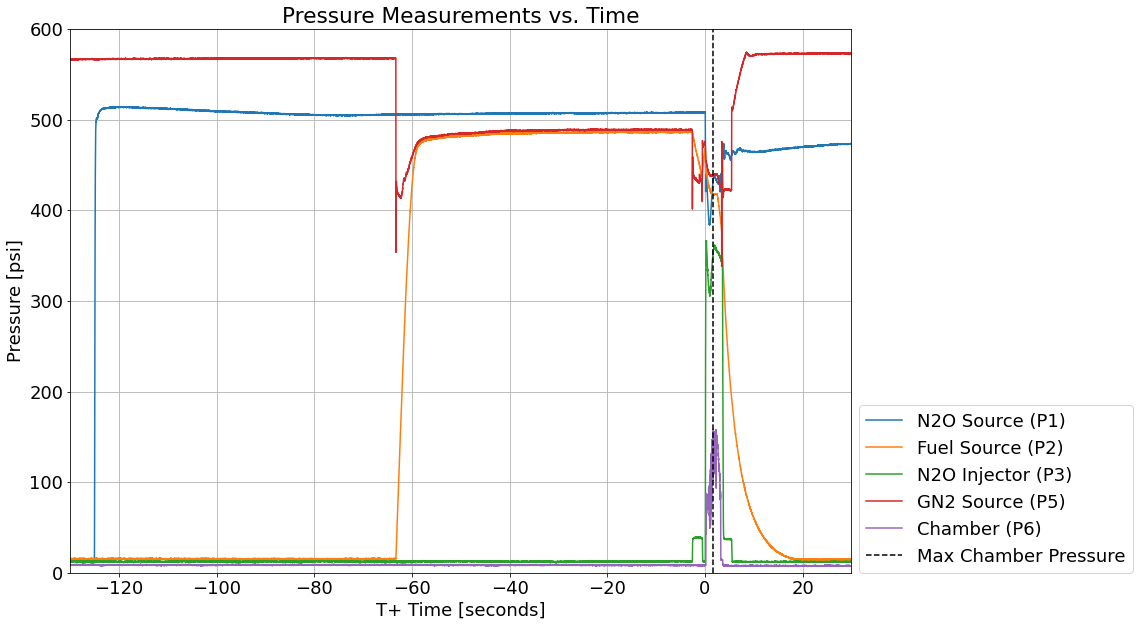

In [4]:
def plot_pressure(event_names=[], event_times=[], x1=-130, x2=30):
    # Plot all pressures
    plt.plot(data["T+ Time (seconds)"], data[P1].rolling(WINDOW, center=True).mean(), label="N2O Source (P1)")
    plt.plot(data["T+ Time (seconds)"], data[P2].rolling(WINDOW, center=True).mean(), label="Fuel Source (P2)")
    plt.plot(data["T+ Time (seconds)"], data[P3].rolling(WINDOW, center=True).mean(), label="N2O Injector (P3)")
    plt.plot(data["T+ Time (seconds)"], data[P5].rolling(WINDOW, center=True).mean(), label="GN2 Source (P5)")
    plt.plot(data["T+ Time (seconds)"], data[P6].rolling(WINDOW, center=True).mean(), label=f"Chamber (P6)")
    
    # Calc, print and plot max chamber pressure
    smoothed_pressure = data[P6].rolling(WINDOW, center=True).mean()
    max_press = smoothed_pressure.max()
    max_press_time = data["T+ Time (seconds)"][smoothed_pressure.idxmax()]
    print(f"Max Chamber Pressure occurs at T+{max_press_time} seconds at a value of {max_press} psi.")
    plt.axvline(max_press_time, 0, 1, c='k', linestyle="dashed", label="Max Chamber Pressure")

    # Add vertical dashed lines for user-specified events
    colors = iter(plt.cm.coolwarm(np.linspace(0, 1, len(event_names))))
    for i, name in enumerate(event_names):
        plt.axvline(event_times[i], 0, 1, c=next(colors), linestyle="dashed", label=name)

    # Use input x-limits
    plt.xlim(x1, x2)
    plt.ylim(0, 600)

    # Configure/show plot
    plt.legend(loc=(1.01, 0))
    plt.title("Pressure Measurements vs. Time")
    plt.xlabel("T+ Time [seconds]")
    plt.ylabel("Pressure [psi]")
    plt.gcf().set_size_inches(14, 10)
    plt.gcf().set_facecolor("white")
    plt.grid(True)
    plt.show()

plot_pressure()

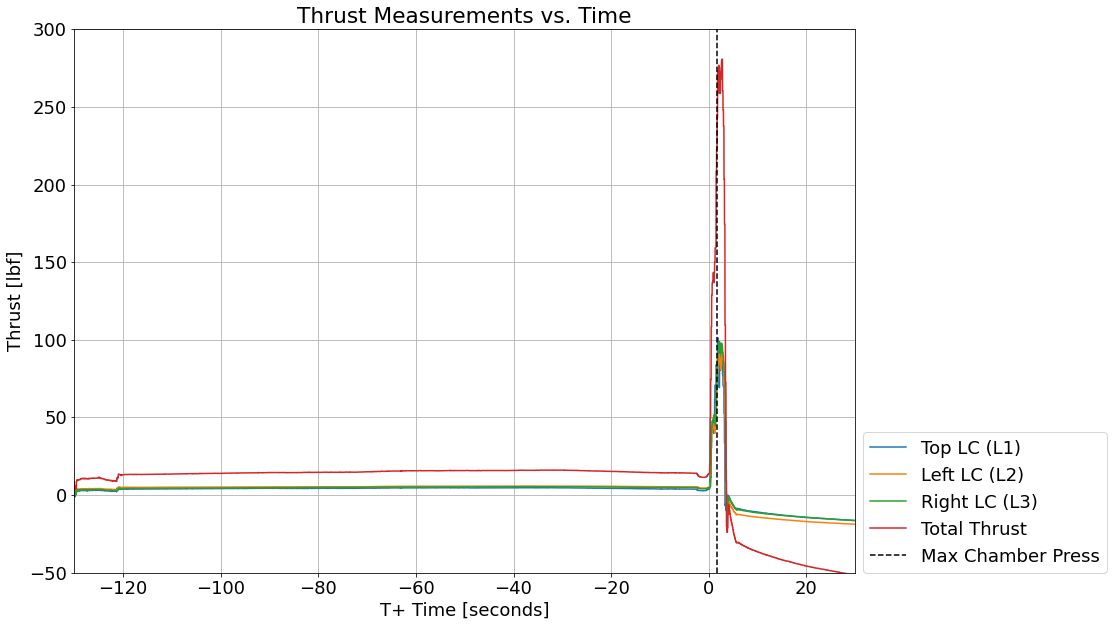

In [5]:
def plot_thrust(event_names=[], event_times=[], x1=-130, x2=30):
    # Plot Load Cell data (convert negative (compressive) values to thrust)
    plt.plot(data["T+ Time (seconds)"], -1*data[L1], label="Top LC (L1)")
    plt.plot(data["T+ Time (seconds)"], -1*data[L2], label="Left LC (L2)")
    plt.plot(data["T+ Time (seconds)"], -1*data[L3], label="Right LC (L3)")
    plt.plot(data["T+ Time (seconds)"], -1*(data[L1] + data[L2] + data[L3]), label="Total Thrust")

    # Calc/show line for max press
    max_press_time = data["T+ Time (seconds)"][data[P6].rolling(WINDOW, center=True).mean().idxmax()]
    plt.axvline(max_press_time, 0, 1, c='k', linestyle="dashed", label="Max Chamber Press")

    # Add vertical dashed lines for user-specified events
    colors = iter(plt.cm.coolwarm(np.linspace(0, 1, len(event_names))))
    for i, name in enumerate(event_names):
        plt.axvline(event_times[i], 0, 1, c=next(colors), linestyle="dashed", label=name)

    # Use input x-limits
    plt.xlim(x1, x2)
    plt.ylim(-50, 300)

    # Configure/show plot
    plt.legend(loc=(1.01, 0))
    plt.title("Thrust Measurements vs. Time")
    plt.xlabel("T+ Time [seconds]")
    plt.ylabel("Thrust [lbf]")
    plt.gcf().set_size_inches(14, 10)
    plt.gcf().set_facecolor("white")
    plt.grid(True)
    plt.show()

plot_thrust()

Max Chamber Pressure occurs at T+1.716 seconds at a value of 158.81363636363636 psi.


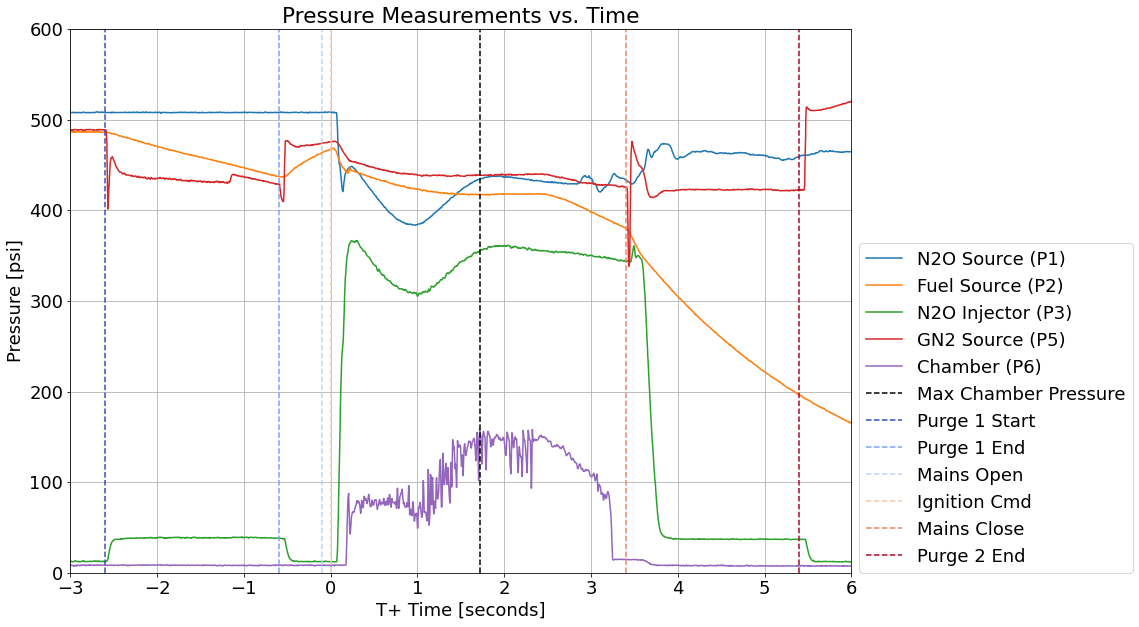

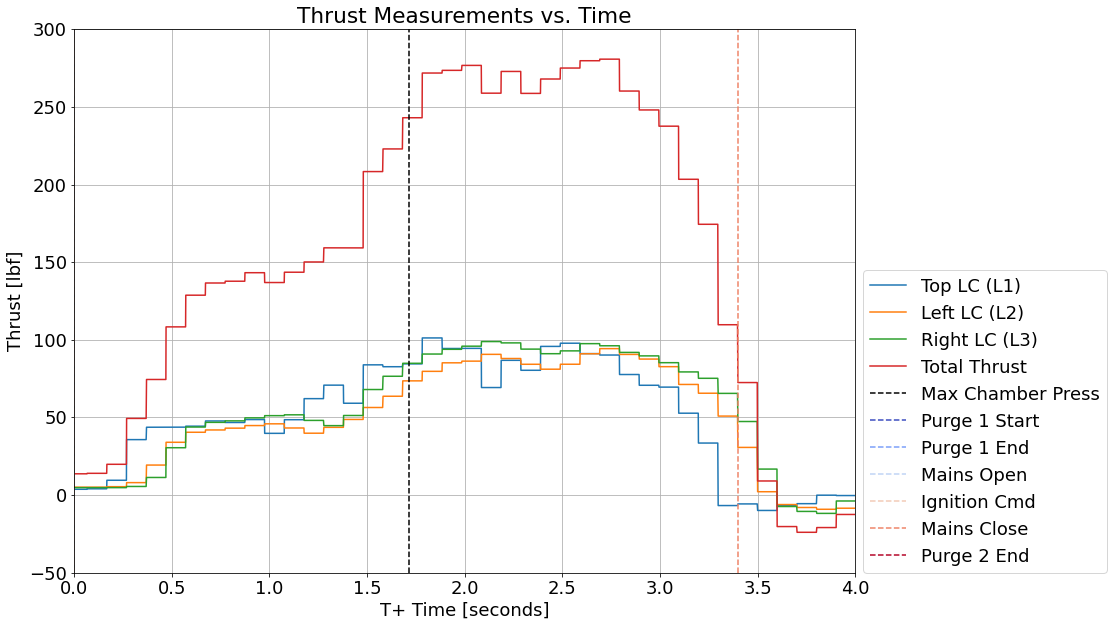

In [10]:
plot_pressure(EVENT_NAMES, EVENT_TIMES, -3, 6)
plot_thrust(EVENT_NAMES, EVENT_TIMES, 0, 4)

## Animation
Goal is 33.33 ms per frame, eventually sync to videos of hotfire

In [7]:
def animate_pressure(event_names=[], event_times=[], x1=-130, x2=30):
    # Only calc smoothed pressure and max once
    smoothed_pressure = data[P6].rolling(WINDOW, center=True).mean()
    max_press_time = data["T+ Time (seconds)"][smoothed_pressure.idxmax()]
    
    for i in tqdm(range(int((x2-x1) * 30 + 1))):
        t = x1 + i/30
        
        # Isolate data for current frame
        averaging_data = data[(data['T+ Time (seconds)'] < t) & (data['T+ Time (seconds)'] > (t - 1/30))]

        # Plot all pressures
        plt.plot(data["T+ Time (seconds)"], data[P1].rolling(WINDOW, center=True).mean(), label=f"N2O Source (P1)       ={averaging_data[P1].mean():.5g} psi")
        plt.plot(data["T+ Time (seconds)"], data[P2].rolling(WINDOW, center=True).mean(), label=f"Fuel Source (P2)       ={averaging_data[P2].mean():.5g} psi")
        plt.plot(data["T+ Time (seconds)"], data[P3].rolling(WINDOW, center=True).mean(), label=f"N2O Injector (P3)      ={averaging_data[P3].mean():.5g} psi")
        plt.plot(data["T+ Time (seconds)"], data[P5].rolling(WINDOW, center=True).mean(), label=f"GN2 Source (P5)       ={averaging_data[P5].mean():.5g} psi")
        plt.plot(data["T+ Time (seconds)"], data[P6].rolling(WINDOW, center=True).mean(), label=f"Chamber (P6)           ={averaging_data[P6].mean():.5g} psi")

        # Plot max pressure line, with extra spacing to guarantee constant figure size
        plt.axvline(max_press_time, 0, 1, c='k', linestyle="dashed", label="Max Chamber Pressure                  ")


        # Add vertical dashed lines for user-specified events
        colors = iter(plt.cm.coolwarm(np.linspace(0, 1, len(event_names))))
        for index, name in enumerate(event_names):
            plt.axvline(event_times[index], 0, 1, c=next(colors), linestyle="dashed", label=name)

        # Plot line for current position
        plt.axvline(t, 0, 1, c='k', linestyle="solid", label=f"Time: T{'-' if t <=0 else '+'}{abs(t):.3f} sec")

        # Use input x-limits
        plt.xlim(x1, x2)
        plt.ylim(0, 600)

        # Configure/show plot
        plt.legend(loc=(1.01, 0))
        plt.title("Pressure Measurements vs. Time")
        plt.xlabel("T+ Time [seconds]")
        plt.ylabel("Pressure [psi]")
        plt.gcf().set_size_inches(14, 10)
        plt.gcf().set_facecolor("white")
        plt.grid(True)
        plt.savefig(f"Pressure Animation/frame_{i}.png", bbox_inches="tight")
        plt.clf()
    plt.close()

if REMAKE_PRESSURE:
    animate_pressure(EVENT_NAMES, EVENT_TIMES, -3, 6)

In [8]:
def animate_thrust(event_names=[], event_times=[], x1=-130, x2=30):
    # Only calc smoothed pressure and max once
    smoothed_pressure = data[P6].rolling(WINDOW, center=True).mean()
    max_press_time = data["T+ Time (seconds)"][smoothed_pressure.idxmax()]
    
    for i in tqdm(range(int((x2-x1) * 30 + 1))):
        t = x1 + i/30
        
        # Isolate data for current frame
        averaging_data = data[(data['T+ Time (seconds)'] < t) & (data['T+ Time (seconds)'] > (t - 1/30))]

        # Plot Load Cell data (convert negative (compressive) values to thrust)
        avg_L1 = -1*averaging_data[L1].mean()
        avg_L2 = -1*averaging_data[L2].mean()
        avg_L3 = -1*averaging_data[L3].mean()
        plt.plot(data["T+ Time (seconds)"], -1*data[L1], label=f"Top LC (L1)     ={avg_L1:.4g} lbf")
        plt.plot(data["T+ Time (seconds)"], -1*data[L2], label=f"Left LC (L2)    ={avg_L2:.4g} lbf")
        plt.plot(data["T+ Time (seconds)"], -1*data[L3], label=f"Right LC (L3)  ={avg_L3:.4g} lbf")
        plt.plot(data["T+ Time (seconds)"], -1*(data[L1] + data[L2] + data[L3]), label=f"Total Thrust    ={(avg_L1 + avg_L2 + avg_L3):.4g} lbf")

        # Calc/show line for max press
        plt.axvline(max_press_time, 0, 1, c='k', linestyle="dashed", label="Max Chamber Pressure                  ")

        # Add vertical dashed lines for user-specified events
        colors = iter(plt.cm.coolwarm(np.linspace(0, 1, len(event_names))))
        for index, name in enumerate(event_names):
            plt.axvline(event_times[index], 0, 1, c=next(colors), linestyle="dashed", label=name)

        # Plot line for current position
        plt.axvline(t, 0, 1, c='k', linestyle="solid", label=f"Time: T{'-' if t <=0 else '+'}{abs(t):.3f} sec")

        # Use input x-limits
        plt.xlim(x1, x2)
        plt.ylim(-50, 300)

        # Configure/show plot
        plt.legend(loc=(1.01, 0))
        plt.title("Thrust Measurements vs. Time")
        plt.xlabel("T+ Time [seconds]")
        plt.ylabel("Thrust [lbf]")
        plt.gcf().set_size_inches(14, 10)
        plt.gcf().set_facecolor("white")
        plt.grid(True)
        plt.savefig(f"Thrust Animation/frame_{i}.png", bbox_inches="tight")
        plt.clf()
    plt.close()

if REMAKE_THRUST:
    animate_thrust(EVENT_NAMES, EVENT_TIMES, -3, 6)

  0%|          | 0/271 [00:00<?, ?it/s]

In [9]:
def animate_pressure_2(event_names=[], event_times=[], x1=-130, x2=30):
    # Only calc smoothed pressure and max once
    smoothed_pressure = data[P6].rolling(WINDOW, center=True).mean()
    max_press_time = data["T+ Time (seconds)"][smoothed_pressure.idxmax()]
    
    for i in tqdm(range(int((x2-x1) * 30 + 1))):
        t = x1 + i/30
        
        # Plot P6
        plt.plot(data["T+ Time (seconds)"], smoothed_pressure[:len(data["T+ Time (seconds)"])], label=f"Chamber (P6)")
        plt.axvline(max_press_time, 0, 1, c='k', linestyle="dashed", label="Max Chamber Pressure")


        # Add vertical dashed lines for user-specified events
        colors = iter(plt.cm.coolwarm(np.linspace(0, 1, len(event_names))))
        for index, name in enumerate(event_names):
            plt.axvline(event_times[index], 0, 1, c=next(colors), linestyle="dashed", label=name)


        # Set current position as the center, with 1 second total window
        plt.xlim(t - 0.5, t + 0.5)
        plt.ylim(0, 175)
        plt.axvline(t, 0, 1, c='k', linestyle="solid", label=f"Time: T{'-' if t <=0 else '+'}{abs(t):.3f} sec")

        # Configure/show plot
        plt.legend(loc=(1.01, 0))
        plt.title("Chamber Pressure vs. Time")
        plt.xlabel("T+ Time [seconds]")
        plt.ylabel("Pressure [psi]")
        plt.gcf().set_size_inches(14, 10)
        plt.gcf().set_facecolor("white")
        plt.grid(True)
        plt.savefig(f"Pressure Animation 2/frame_{i}.png", bbox_inches="tight")
        plt.clf()
    plt.close()

if REMAKE_PRESSURE_2:
    animate_pressure_2(EVENT_NAMES, EVENT_TIMES, -3, 6)